In [1]:
import os
import sys
import numpy as np
import torch
from torch.utils.data import DataLoader
import create_paths
from create_paths import smoothen_paths, check_if_avoids_obstacles
# from create_paths import mat_to_path
import matplotlib.pyplot as plt

import importlib.util
import sys
import data_manager as dm

Configure the evaluation run

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_grad_enabled(False)

DATASET = '20_density'      # (String) The name of the dataset to load. Leave as None to use the same dataset that the model was trained on.
SUBSET = 'eval'     # The name of the subset to load from

RUN_NAME = 'quiet-galaxy-112'
STEP = 351

BATCH_SIZE = 50
SMOOTH_VAL = 5

NUM_SAMPLES = 100     # the number of example outputs to generate
FIG_SCALE = 20      # the number of pixels per inch in the generated plots

Import the gan's class definitions

In [3]:
# Make sure the cell only runs once
try:
    if MODEL_IMPORTED:
        print("Skipping cell")
except:
    config = dm.load_gan(RUN_NAME)

    from GANdefs import Generator
    gen = Generator(config['features_gen'], config['kernels_gen'], config['stride_gen'], config['padding_gen'], device=DEVICE)

    if DATASET == None:
        DATASET = config['dataset']
        SUBSET = config['subset']

MODEL_IMPORTED = True

In [4]:
def path_to_tensor(path, map_dim):
    path_mat = torch.zeros(map_dim)

    # Make the path continuous
    for i in range(path.shape[0] - 1):
        x = int(path[i,1])
        x1 = int(path[i,1])
        x2 = int(path[i+1,1])

        y = int(path[i,0])
        y1 = int(path[i,0])
        y2 = int(path[i+1,0])

        if (x1 < x2):
            x_dir = 1
        else:
            x_dir = -1

        if (y1 < y2):
            y_dir = 1
        else:
            y_dir = -1

        # Determine y from x
        if x2-x1 != 0:
            m = (y2-y1)/(x2-x1)
            while x != x2:
                y = round(m*(x-x1) + y1)
                path_mat[y,x] = 1
                x += x_dir
        else:
            while x != x2:
                path_mat[y1,x] = 1
                x += x_dir


        x = int(path[i,1])
        x1 = int(path[i,1])
        x2 = int(path[i+1,1])

        y = int(path[i,0])
        y1 = int(path[i,0])
        y2 = int(path[i+1,0])

        # Determine x from y
        if y2-y1 != 0:
            m = (x2-x1)/(y2-y1)
            while y != y2:
                x = round(m*(y-y1) + x1)
                path_mat[y,x] = 1
                y += y_dir
        else:
            while y != y2:
                path_mat[y,x1] = 1
                y += y_dir
        
    path_mat[int(path[path.shape[0]-1,0]), int(path[path.shape[0]-1,1])] = 1     # Include the last point in the path

    return torch.tensor(path_mat)

Load the network(s)

In [5]:
# Make sure the cell only runs once
try:
    if MODEL_LOADED:
        print("Skipping cell execution")
except:

    state = dm.load_checkpoint(RUN_NAME, STEP)
    gen.load_state_dict(state['gen'])

MODEL_LOADED = True

Get the input set

In [6]:
# Need to override __init__, __len__, __getitem__
# as per datasets requirement
class PathsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, subset, device='cpu'):
        self.device = device
        self.paths = dm.load_input(dataset, subset) # Load all of the paths in the specified set

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        x = self.paths[idx]
        x = x.to(self.device)
        return x

In [7]:
# Make sure the cell only runs once
try:
    if INPUT_LOADED:
        print("Skipping cell execution")
except:

    inputs = dm.load_input(DATASET, SUBSET)
    dataloader = DataLoader(inputs, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)

INPUT_LOADED = True

Get the resulting outputs

In [8]:
outputs = torch.Tensor()
for item_idx, item in enumerate(dataloader):
    item = item.to(DEVICE)

    # Generate some fake paths
    noise = torch.rand_like(item[:,0:1,:,:])
    noise = torch.cat((noise, item[:,1:,:,:]), axis=1)
    # noise = item[:,1:,:,:]
    fake = gen(noise)

    out = torch.flip(item, [1])     # map, endpoints, truth
    out = torch.cat((out, fake), axis=1)  # map, endpoints, truth, generated (raw)

    out = out.to('cpu')
    outputs = torch.cat((outputs, out), axis=0)
    if item_idx == NUM_SAMPLES:
        break

# Channels: map, endpoints, ground truth, generated (raw)
outputs = outputs[:NUM_SAMPLES,:,:,:]
maps = outputs[:NUM_SAMPLES,:1,:,:]
maps = np.squeeze(maps)
maps[maps > 0] = 0
maps[maps < 0] = 1

round outputs using Rachael's code

In [9]:
# For each item, find start/end points using direct path (where direct path == 2)
# outputs = torch.tensor(outputs)
smooth = torch.zeros_like(outputs[:,-1:,:,:])
success_sum = 0
for i in range(outputs.shape[0]):
    # Find start/end
    ends = torch.nonzero(outputs[i,1,:,:] > 1)
    # ends = torch.flip(ends, [0])

    smoothened_coords = smoothen_paths(outputs[i,-1:,:,:], ends[0], ends[1], smooth_val=SMOOTH_VAL, display=False)[0]

    success_sum += check_if_avoids_obstacles(smoothened_coords[:,1].tolist(), smoothened_coords[:,0].tolist(), maps[i])
    smooth[i] = path_to_tensor(smoothened_coords, outputs[i,-1,:,:].shape)[None,None,:,:]


outputs = torch.cat((outputs, smooth), axis=1)
perc_succ = round(success_sum/outputs.shape[0]*100, 4)

# Channels: map, endpoints, ground truth, generated (raw), generated (smooth)

/home/user/Documents/GAN-NN/create_paths.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obstacle_coords = torch.fliplr(torch.nonzero(torch.tensor(map))).tolist()
/tmp/ipykernel_32360/3734535675.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(path_mat)


Format and save input, raw output, and rounded path

Percent of successful paths: 86.0%


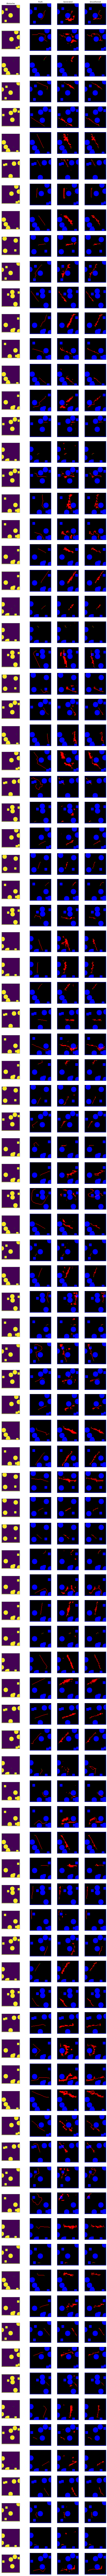

In [10]:
print(f"Percent of successful paths: {perc_succ}%")

outputs = np.asarray(outputs)

fig = plt.figure(figsize=(max(4, 4*outputs[0,0,:,:].shape[1]/FIG_SCALE),max(NUM_SAMPLES*(outputs[0,0,:,:].shape[1]/outputs[0,0,:,:].shape[0]), NUM_SAMPLES*outputs[0,0,:,:].shape[0]/FIG_SCALE)))

col_title = True
for i in range(NUM_SAMPLES):

    endpoints = np.squeeze(np.nonzero(outputs[i,1,:,:] == 2))

    # Show map
    sub = fig.add_subplot(NUM_SAMPLES,5,i*5+1)
    sub.set_xticks([])
    sub.set_yticks([])
    plt.imshow(maps[i])
    plt.plot(endpoints[1,:],endpoints[0,:], 'g.')
    if col_title:
        plt.title('Obstacles')

    # show real path
    sub = fig.add_subplot(NUM_SAMPLES,4,i*4+2)
    sub.set_xticks([])
    sub.set_yticks([])
    plt.imshow(np.stack((outputs[i,2,:,:], np.zeros_like(outputs[i,2,:,:]), maps[i]), axis=-1))
    plt.plot(endpoints[1,:],endpoints[0,:], 'g.')
    if col_title:
        plt.title('Truth')

    # show raw gan output
    sub = fig.add_subplot(NUM_SAMPLES,4,i*4+3)
    sub.set_xticks([])
    sub.set_yticks([])
    plt.imshow(np.stack((outputs[i,3,:,:], np.zeros_like(outputs[i,3,:,:]), maps[i]), axis=-1))
    plt.plot(endpoints[1,:],endpoints[0,:], 'g.')
    if col_title:
        plt.title('Generated')

    # Show smoothened gan output
    sub = fig.add_subplot(NUM_SAMPLES,4,i*4+4)
    sub.set_xticks([])
    sub.set_yticks([])
    plt.imshow(np.stack((outputs[i,-1,:,:], np.zeros_like(outputs[i,4,:,:]), maps[i]), axis=-1))
    plt.plot(endpoints[1,:],endpoints[0,:], 'g.')
    if col_title:
        plt.title('Smoothened')

    col_title = False

plt.show()